- Test the robustness of findings under different high-risk group sizes: s_H=10^{-2,-1,1}; half-life=2 day; network of 10^5 nodes
- Reproduce Fig.4 in the paper 

In [40]:
import simsom.utils as utils
import numpy as np
import pandas as pd
import os
import glob

## Helpers

In [41]:
def get_agg_metric(
    df,
    group_key="base_name",
    new_col_prefix="baseline",
    metrics=[
        "quality",
        "illegal_frac",
        "unique_illegal_frac",
        "illegal_count",
        "unique_illegal_count",
    ],
    retain_keys=["illegal_prob"],
):
    """
    Return a df where the columns of interest are aggregated by mean and std & renamed (prefix with a phrase)
    new_col_prefix (str): the prefix to append to aggregated cols
    """
    if any(i not in df.columns for i in retain_keys):
        raise ValueError(
            "retain_keys, e.g., `illegal_prob` column not found in the dataframe. This is needed as a dummy column to count the number of observations."
        )
    for metric in metrics:
        df[f"{metric}_std"] = df[metric]
        df = df.rename(columns={metric: f"{metric}_mean"})

    # aggregate (by mean or std)
    agg = dict()
    for col in retain_keys:
        if col == "illegal_prob":
            agg[col] = "count"
        else:
            agg[col] = "first"
    for metric in metrics:
        agg[f"{metric}_mean"] = "mean"
        agg[f"{metric}_std"] = "std"
    try:
        agg_df = df.groupby(group_key).agg(agg).reset_index()
        # rename aggregated cols with the prefix
        agg_cols = (
            [f"{metric}_mean" for metric in metrics]
            + [f"{metric}_std" for metric in metrics]
            + retain_keys
        )
        rename_dict = {col: f"{new_col_prefix}_{col}" for col in agg_cols}
        rename_dict["illegal_prob"] = f"{new_col_prefix}_no_observations"
        agg_df = agg_df[agg_cols + [group_key]].rename(columns=rename_dict)
    except Exception as e:
        print(e)
        raise ValueError(
            "Unable to groupby or rename col, most likely the specified group_key or retain_cols don't exist."
        )
    return agg_df


def get_delay_from_name(string):
    # 4_0.01__diff_true -> 4
    delay = string.split("__")[0].split("_")[0]
    if delay != "b":
        return float(delay)
    else:
        return -1


## Format violin plot

In [42]:
import seaborn as sns

# orange, blue, teal, purpple, yellow, pink
BLUEPALETTE = ["#F18447", "#3863AC", "#209B8A", "#550F6B", "#F8D625", "#BC3684"]


def patch_violinplot(ax, palette=BLUEPALETTE, n=1, alpha=1, multicolor=True):
    """
    Recolor the outlines of violin patches using a palette
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PolyCollection

    violins = [art for art in ax.get_children() if isinstance(art, PolyCollection)]
    for i in range(len(violins)):
        if multicolor is False:
            violins[i].set_edgecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_edgecolor(colors[i])
        violins[i].set_alpha(alpha)


def point_violinplot(
    ax,
    palette=BLUEPALETTE,
    n=1,
    pointsize=200,
    edgecolor="white",
    multicolor=True,
    linewidth=1.5,
):
    """
    Recolor points in the plot based on the violin facecolor
    - palette (list of str): color palette for the patches
    - n (int): number of colors to use from the palette
    - edgecolor (str): point outline color
    - pointsize (int): point size
    - multicolor (bool): whether to color the patches differently. If False, use the default color (orange)
    - alpha (float): transparency
    """
    from matplotlib.collections import PathCollection

    violins = [art for art in ax.get_children() if isinstance(art, PathCollection)]
    for i in range(len(violins)):
        violins[i].set_sizes([pointsize])  # size
        violins[i].set_edgecolor(edgecolor)  # outline
        violins[i].set_linewidth(linewidth)
        if multicolor is False:
            violins[i].set_facecolor(c="#F18447")
        else:
            colors = sns.color_palette(palette, n_colors=n) * (len(violins) // n)
            violins[i].set_facecolor(colors[i])

## Extract s_H from name

In [43]:
import re


def extract_float(input_str):
    # Define the regular expression pattern to match the float
    pattern = r"[a-zA-Z0-9]_(\d+(\.\d+)?)__diff_true"

    # Search for the pattern in the input string
    match = re.search(pattern, input_str)

    # If a match is found, extract the float part
    if match:
        return float(match.group(1))
    else:
        raise ValueError("The input string does not match the expected format")


# Example usage
input_str1 = "1_1__diff_true"
input_str2 = "b_10__diff_true"

extracted_float1 = extract_float(input_str1)
extracted_float2 = extract_float(input_str2)

print(extracted_float1)  # Output: 0.002
print(extracted_float2)  # Output: 0.002

1.0
10.0


## Bonferroni correction

In [44]:
def bonferroni_correction(p_value, n_comparisons):
    """
    Perform Bonferroni correction on a given p-value for multiple comparisons.
    Parameters:
    -----------
    - p_value (float): The original p-value.
    - n_comparisons (int): The number of comparisons being made.
    Returns:
    -----------
    - float: The Bonferroni corrected p-value.
    """
    bonferroni_corrected_p_value = p_value * n_comparisons
    # Ensure the corrected p-value is not greater than 1
    bonferroni_corrected_p_value = min(1.0, bonferroni_corrected_p_value)
    return bonferroni_corrected_p_value

In [45]:
def get_corrected_p(plot_data, focal_col="s_H", sig_level=0.05):
    # Return a dataframe with corrected p-values for all pairs of probabilities in the plot data
    from scipy.stats import mannwhitneyu

    results = []
    probs = sorted(plot_data[focal_col].dropna().unique())
    pairs = [
        (probs[i], probs[j])
        for i in range(len(probs))
        for j in range(i + 1, len(probs))
    ]
    for pair in pairs:
        pop1 = plot_data[plot_data[focal_col] == pair[0]]["pct_change"]
        pop2 = plot_data[plot_data[focal_col] == pair[1]]["pct_change"]
        U, p = mannwhitneyu(pop1, pop2, method="exact")
        results.append({"pair": pair, "U": U, "p": p})
    stats = pd.DataFrame(results)
    stats["corrected_p"] = stats["p"].apply(
        lambda x: bonferroni_correction(x, len(pairs))
    )
    print("p-values:", stats)
    significant_pairs = stats[stats.corrected_p < sig_level]["pair"].tolist()
    print(f"Significant pairs (p<{sig_level}): ", significant_pairs)
    return stats, significant_pairs

## Annotation 

In [46]:
# Define the annotation legend
annotation_legend = {
    (0.05, 1.00): "ns",
    (0.01, 0.05): "ns",
    (0.001, 0.01): "*",
    (0.0001, 0.001): "**",
    (0.0, 0.0001): "***",
}


# Function to get the annotation based on p-value
def get_annotation(p_value):
    for (lower, upper), annotation in annotation_legend.items():
        if lower < p_value <= upper:
            return annotation
    return "Invalid p-value"


# Function to add annotations
def add_annotation(ax, x1, x2, y, text):
    ax.plot([x1, x1, x2, x2], [y, y + 1, y + 1, y], lw=1.5, color="k")
    ax.text(
        (x1 + x2) * 0.5, y + 1, text, ha="center", va="bottom", color="k", fontsize=12
    )

# Read data
## tau=1

In [47]:
# Directory containing experiment results
ABS_PATH = "/N/u/baotruon/BigRed200/carisma/experiments/20241126_sH"
fpaths = glob.glob(f"{ABS_PATH}/prevalence*/*.parquet")
dfs = []
for idx, fpath in enumerate(fpaths):
    if idx % 5 == 0:
        print(f"Processing {idx}/{len(fpaths)}")
    raw = pd.read_parquet(fpath, engine="pyarrow")
    dfs += [raw]
tau1 = pd.concat(dfs, ignore_index=True)

Processing 0/40
Processing 5/40
Processing 10/40
Processing 15/40
Processing 20/40
Processing 25/40
Processing 30/40
Processing 35/40


## tau=8

In [48]:
# Directory containing experiment results
ABS_PATH = "/N/u/baotruon/BigRed200/carisma/experiments/20250112_sH"
fpaths = glob.glob(f"{ABS_PATH}/prevalence*/*.parquet")
dfs = []
for idx, fpath in enumerate(fpaths):
    if idx % 5 == 0:
        print(f"Processing {idx}/{len(fpaths)}")
    raw = pd.read_parquet(fpath, engine="pyarrow")
    dfs += [raw]
tau8 = pd.concat(dfs, ignore_index=True)

Processing 0/20
Processing 5/20
Processing 10/20
Processing 15/20


In [49]:
combined = pd.concat([tau1, tau8], ignore_index=True)

In [50]:
combined["base_name"] = combined["fpath"].apply(lambda x: os.path.basename(x))
combined["s_H"] = combined["base_name"].apply(extract_float)
print("s_H values:", combined["s_H"].unique())
print("len combined data: ", len(combined))
data = combined[~combined["unique_illegal_frac"].isna()]
print("len combined data (after removing nans): ", len(data))

s_H values: [ 0.1 10.   1. ]
len combined data:  420
len combined data (after removing nans):  420


In [51]:
data["half_life"] = data.apply(
    lambda row: -1 if "b_" in row["base_name"] else row["moderation_half_life"], axis=1
)
retain_cols = [
    "illegal_frac",
    "unique_illegal_frac",
    "illegal_count",
    "unique_illegal_count",
    "s_H",
    "half_life",
]
data = data[retain_cols]
data.head()

,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,s_H,half_life
0,0.004503,0.002620,669,14,0.1,2.0
1,0.009259,0.011238,1388,59,0.1,-1.0
2,0.005624,0.004229,843,23,10.0,2.0
3,0.004910,0.005426,735,28,1.0,2.0
4,0.008692,0.010021,1303,56,1.0,-1.0


In [52]:
data.half_life.unique()

array([ 2., -1.,  8.])

# Count number of observations for each param

## Baseline

In [53]:
# Count the number of rows for each combination of 'half_life' and 'illegal_content_probability'
data[data.half_life == -1].groupby("s_H").size()

s_H
0.1     60
1.0     60
10.0    60
dtype: int64

## Non-baseline

In [54]:
# Count the number of rows for each combination of 'moderation_half_life' and 'illegal_content_probability'
row_counts = (
    data[data.half_life != -1]
    .groupby(["s_H", "half_life"])
    .size()
    .reset_index(name="count")
)

# Display the result
row_counts.sort_values(by=["s_H"])

,s_H,half_life,count
0,0.1,2.0,60
1,0.1,8.0,20
2,1.0,2.0,60
3,1.0,8.0,20
4,10.0,2.0,60
5,10.0,8.0,20


## Min number of simulations: 20

In [55]:
min(row_counts[row_counts["half_life"] == 8]["count"])

20

# Pct change: metric-baseline_median / (baseline_median)

In [56]:
# dummy column to count the number of observations
data["illegal_prob"] = 1
baseline = data[data.half_life == -1]

baseline = get_agg_metric(
    baseline,
    group_key="s_H",
    new_col_prefix="baseline",
    metrics=[
        "illegal_frac",
        "unique_illegal_frac",
    ],
    retain_keys=["illegal_prob", "half_life"],
)

/tmp/ipykernel_95210/334309585.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"{metric}_std"] = df[metric]


In [57]:
baseline

,baseline_illegal_frac_mean,baseline_unique_illegal_frac_mean,baseline_illegal_frac_std,baseline_unique_illegal_frac_std,baseline_no_observations,baseline_half_life,s_H
0,0.009197,0.010037,0.001581,0.001445,60,-1.0,0.1
1,0.009766,0.010157,0.002843,0.001226,60,-1.0,1.0
2,0.011255,0.010233,0.008117,0.001704,60,-1.0,10.0


## Get pct change

In [58]:
results = data[data.half_life != -1]
results = results.merge(baseline, on="s_H", how="left")

In [59]:
results.head()

,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,s_H,half_life,illegal_prob,baseline_illegal_frac_mean,baseline_unique_illegal_frac_mean,baseline_illegal_frac_std,baseline_unique_illegal_frac_std,baseline_no_observations,baseline_half_life
0,0.004503,0.002620,669,14,0.1,2.0,1,0.009197,0.010037,0.001581,0.001445,60,-1.0
1,0.005624,0.004229,843,23,10.0,2.0,1,0.011255,0.010233,0.008117,0.001704,60,-1.0
2,0.004910,0.005426,735,28,1.0,2.0,1,0.009766,0.010157,0.002843,0.001226,60,-1.0
3,0.005235,0.004538,784,24,0.1,2.0,1,0.009197,0.010037,0.001581,0.001445,60,-1.0
4,0.005812,0.004167,869,23,10.0,2.0,1,0.011255,0.010233,0.008117,0.001704,60,-1.0


In [60]:
results = results[~results.unique_illegal_frac.isna()]

In [61]:
metric = "unique_illegal_frac"
results["pct_change"] = (
    (results[f"baseline_{metric}_mean"] - results[metric])
    / results[f"baseline_{metric}_mean"]
    * 100
)

In [62]:
results.head()

,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,s_H,half_life,illegal_prob,baseline_illegal_frac_mean,baseline_unique_illegal_frac_mean,baseline_illegal_frac_std,baseline_unique_illegal_frac_std,baseline_no_observations,baseline_half_life,pct_change
0,0.004503,0.002620,669,14,0.1,2.0,1,0.009197,0.010037,0.001581,0.001445,60,-1.0,73.894279
1,0.005624,0.004229,843,23,10.0,2.0,1,0.011255,0.010233,0.008117,0.001704,60,-1.0,58.676141
2,0.004910,0.005426,735,28,1.0,2.0,1,0.009766,0.010157,0.002843,0.001226,60,-1.0,46.573297
3,0.005235,0.004538,784,24,0.1,2.0,1,0.009197,0.010037,0.001581,0.001445,60,-1.0,54.790416
4,0.005812,0.004167,869,23,10.0,2.0,1,0.011255,0.010233,0.008117,0.001704,60,-1.0,59.275146


# Statistical significance: pct change 

In [63]:
# !pip install statsmodels
from statannotations.stats.ComparisonsCorrection import ComparisonsCorrection

In [64]:
from scipy.stats import mannwhitneyu

probs = sorted(results.s_H.dropna().unique())
pairs = [
    (probs[i], probs[j]) for i in range(len(probs)) for j in range(i + 1, len(probs))
]
pairs

[(0.1, 1.0), (0.1, 10.0), (1.0, 10.0)]

## Filter tau=2 (sample a subset of data)

In [65]:
focal_col = "s_H"  # column being tested in the significance test
sample_tau2 = []
for p in probs:
    sample = results[(results.half_life == 2) & (results[focal_col] == p)].sample(
        20, random_state=15
    )
    sample_tau2.append(sample)

focal = pd.concat(sample_tau2)
stat_res = []
for pair in pairs:
    pop1 = focal[focal[focal_col] == pair[0]]["pct_change"]
    pop2 = focal[focal[focal_col] == pair[1]]["pct_change"]
    U, p = mannwhitneyu(pop1, pop2, method="exact")
    stat_res.append({"pair": pair, "U": U, "p": p})
df = pd.DataFrame(stat_res)

In [66]:
df

,pair,U,p
0,"(0.1, 1.0)",216.0,0.678306
1,"(0.1, 10.0)",173.0,0.477691
2,"(1.0, 10.0)",156.0,0.242270


In [67]:
df["corrected_p"] = df["p"].apply(lambda x: bonferroni_correction(x, len(pairs)))
df

,pair,U,p,corrected_p
0,"(0.1, 1.0)",216.0,0.678306,1.000000
1,"(0.1, 10.0)",173.0,0.477691,1.000000
2,"(1.0, 10.0)",156.0,0.242270,0.726809


# Plot pctchange 

pctchange = treatment - avg_control/avg_control


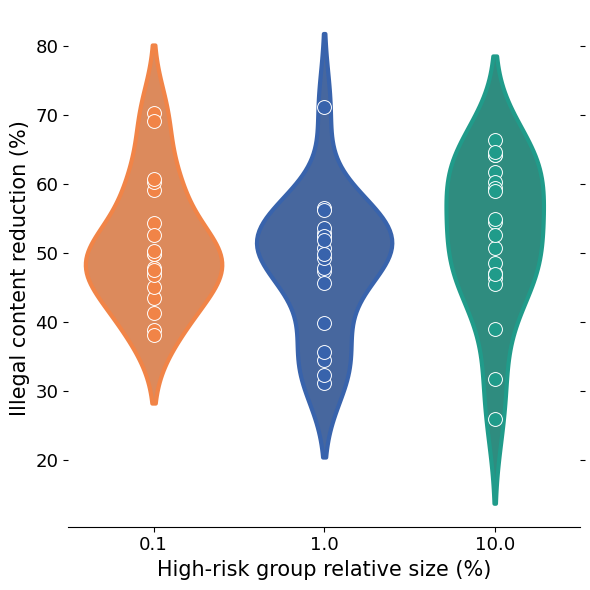

In [68]:
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from matplotlib.ticker import FuncFormatter

PLOT_DIR = "plots_new"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

plt.style.use("stylesheet.mplstyle")
fpath = os.path.join(PLOT_DIR, f"pct_change_s_H_tau2")

plot_data = focal
fig, ax = plt.subplots(figsize=(6, 6))

# Get unique probabilities and sort them
probs = sorted(focal.s_H.unique())

# Create the violin plot
violin = sns.violinplot(
    data=plot_data,
    x="s_H",
    y="pct_change",
    order=probs,
    inner="point",
    palette=BLUEPALETTE,
)

violin.set_ylabel("Illegal content reduction (%)")
violin.set_xlabel("High-risk group relative size (%)")
patch_violinplot(ax, palette=BLUEPALETTE, n=len(probs))
point_violinplot(ax, palette=BLUEPALETTE, n=len(probs), pointsize=100, linewidth=0.7)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
sns.despine(top=True, left=True, bottom=False)

# ax.set_ylim(0, 100)
# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf", dpi=300)
    fig.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()

# Save tau=2 data to an object

In [69]:
tau2_res = plot_data

## Filter tau=8

In [70]:
focal = results[results.half_life == 8]
stat_res = []
for pair in pairs:
    pop1 = focal[focal.s_H == pair[0]]["pct_change"]
    pop2 = focal[focal.s_H == pair[1]]["pct_change"]
    U, p = mannwhitneyu(pop1, pop2, method="exact")
    stat_res.append({"pair": pair, "U": U, "p": p})
df = pd.DataFrame(stat_res)

In [71]:
df

,pair,U,p
0,"(0.1, 1.0)",193.0,0.861987
1,"(0.1, 10.0)",201.0,0.989332
2,"(1.0, 10.0)",206.0,0.883057


In [72]:
df["corrected_p"] = df["p"].apply(lambda x: bonferroni_correction(x, len(pairs)))
df

,pair,U,p,corrected_p
0,"(0.1, 1.0)",193.0,0.861987,1.0
1,"(0.1, 10.0)",201.0,0.989332,1.0
2,"(1.0, 10.0)",206.0,0.883057,1.0


# Plot pctchange 

pctchange = treatment - avg_control/avg_control


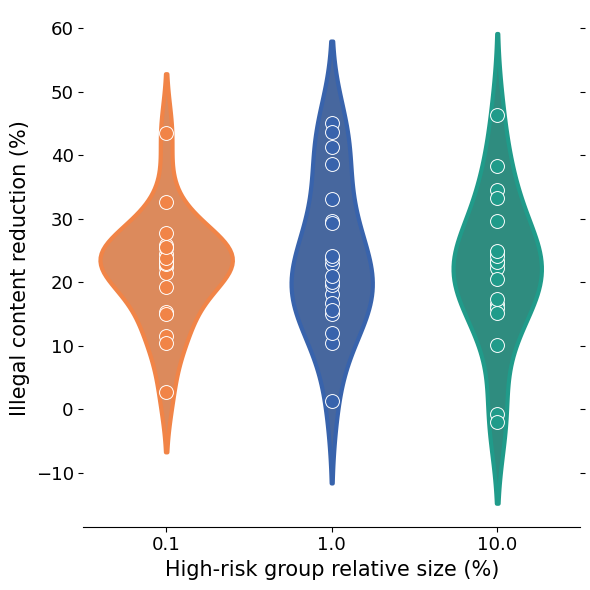

In [73]:
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from matplotlib.ticker import FuncFormatter

PLOT_DIR = "plots_new"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)

plt.style.use("stylesheet.mplstyle")
fpath = os.path.join(PLOT_DIR, f"pct_change_s_H_tau8")

plot_data = focal
fig, ax = plt.subplots(figsize=(6, 6))

# Get unique probabilities and sort them
probs = sorted(focal.s_H.unique())

# Create the violin plot
violin = sns.violinplot(
    data=plot_data,
    x="s_H",
    y="pct_change",
    order=probs,
    inner="point",
    palette=BLUEPALETTE,
)

violin.set_ylabel("Illegal content reduction (%)")
violin.set_xlabel("High-risk group relative size (%)")
patch_violinplot(ax, palette=BLUEPALETTE, n=len(probs))
point_violinplot(ax, palette=BLUEPALETTE, n=len(probs), pointsize=100, linewidth=0.7)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
sns.despine(top=True, left=True, bottom=False)

# ax.set_ylim(0, 100)
# Saving
plt.tight_layout()

fig = violin.get_figure()
if fpath is not None:
    fig.savefig(f"{fpath}.pdf", dpi=300)
    fig.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()

# Save tau=8 data to an object

In [74]:
tau8_res = plot_data

# Plot in panel

In [75]:
from statannotations.Annotator import Annotator
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from matplotlib.ticker import FuncFormatter

plt.style.use("stylesheet.mplstyle")
PLOT_DIR = "plots_new"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)
fpath = os.path.join(PLOT_DIR, f"pct_change_s_H_combine")

p-values:           pair      U         p  corrected_p
0   (0.1, 1.0)  216.0  0.678306     1.000000
1  (0.1, 10.0)  173.0  0.477691     1.000000
2  (1.0, 10.0)  156.0  0.242270     0.726809
Significant pairs (p<0.001):  []
p-values:           pair      U         p  corrected_p
0   (0.1, 1.0)  193.0  0.861987          1.0
1  (0.1, 10.0)  201.0  0.989332          1.0
2  (1.0, 10.0)  206.0  0.883057          1.0
Significant pairs (p<0.001):  []


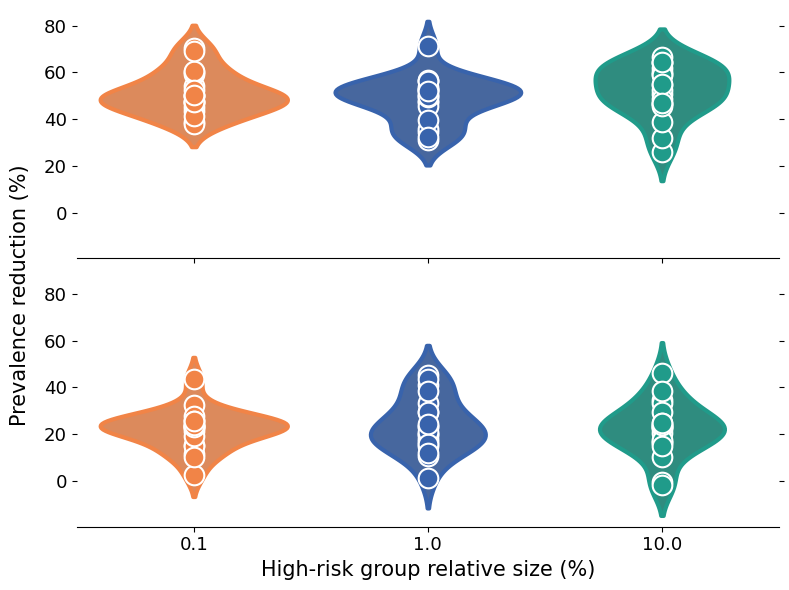

In [76]:
plot_dfs = [tau2_res, tau8_res]
y_label = "Prevalence reduction (%)"

sig_level = 0.001
fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True, sharey=True)
probs = []
for idx, plot_data in enumerate(plot_dfs):
    ax = axs[idx]
    if idx == 0:
        probs = sorted(focal.s_H.unique())

    # Create the violin plot
    violin = sns.violinplot(
        ax=ax,
        data=plot_data,
        x="s_H",
        y="pct_change",
        order=probs,
        inner="point",
        palette=BLUEPALETTE,
    )
    if idx == len(plot_dfs) - 1:
        violin.set_xlabel("High-risk group relative size (%)")
    else:
        violin.set_xlabel("")
    violin.set_ylabel("")

    patch_violinplot(ax, palette=BLUEPALETTE, n=len(probs))
    point_violinplot(ax, palette=BLUEPALETTE, n=len(probs))
    ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
    sns.despine(top=True, left=True, bottom=False)

    ## TEST SIGNIFICANCE
    stats, significant_pairs = get_corrected_p(
        plot_data, focal_col="s_H", sig_level=sig_level
    )
    significant_pairs = [
        i for i in significant_pairs if i[0] in probs and i[1] in probs
    ]
    # Add annotations for significant pairs
    y_max = plot_data["pct_change"].max()
    for x1, x2 in significant_pairs:
        stat, p = stats[stats["pair"] == (x1, x2)][["U", "corrected_p"]].values[0]
        if p < sig_level:
            y = y_max + 5  # Adjust the y position for the annotation
            add_annotation(ax, probs.index(x1), probs.index(x2), y, get_annotation(p))
            print(f"Pair ( {x1}, {x2} ): p-value: {p:.2e}")
            y_max += 10  # Increment y_max for the next annotation

    # ax.set_ylim(0, 100)
fig.supylabel(y_label, fontsize=15)
# Saving
plt.tight_layout()

if fpath is not None:
    plt.savefig(f"{fpath}.pdf", dpi=300)
    plt.savefig(f"{fpath}.png", dpi=300)
else:
    plt.show()